In [1]:
using AA222
using PyPlot
srand(10)

Loading help data...


# Polynomial Models

Let's generate some random data according to a noisy function
$$f(x) = x^2 + \epsilon$$
where $\epsilon \sim \mathcal{N}(0, 0.2^2)$.

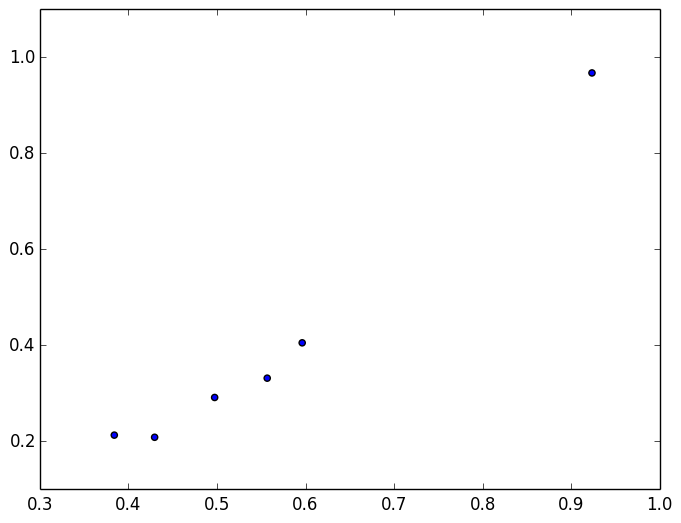

In [1]:
X = rand(6)' # six random input points
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

Vandermonde matrix:
$$\Phi(x) = \left[\begin{matrix} 1 & x_1 & x_1^2 & \cdots & x_1^m \\ 1 & x_2 & x_2^2 & \cdots & x_2^m \\ & & \vdots \\ 1 & x_n & x_n^2 & \cdots & x_n^m \end{matrix}\right]$$

In [2]:
function vander(X, order)
    Phi = zeros(length(X), order + 1)
    for i = 1:length(X)
        Phi[i,:] = [X[i]^k for k = 0:order]
    end
    return Phi
end

vander (generic function with 1 method)

In [3]:
vander(X,3)

6x4 Array{Float64,2}:
 1.0  0.556684  0.309897  0.172515 
 1.0  0.596172  0.355421  0.211892 
 1.0  0.384032  0.147481  0.0566374
 1.0  0.923354  0.852582  0.787235 
 1.0  0.497335  0.247342  0.123012 
 1.0  0.42957   0.18453   0.0792685

$\hat f(x) = \hat w^\top \Phi(x)$  
$\hat w = \Phi^+(x) y$ (least-squares estimate)  
$\Phi^+ = (\Phi^\top \Phi)^{-1} \Phi^\top$ (Moore-Penrose pseudo-inverse)

In [4]:
function polyfit(X, y, order)
    w = pinv(vander(X, order)) * y'
    return x -> dot(w, vander(x, order))
end    

polyfit (generic function with 1 method)

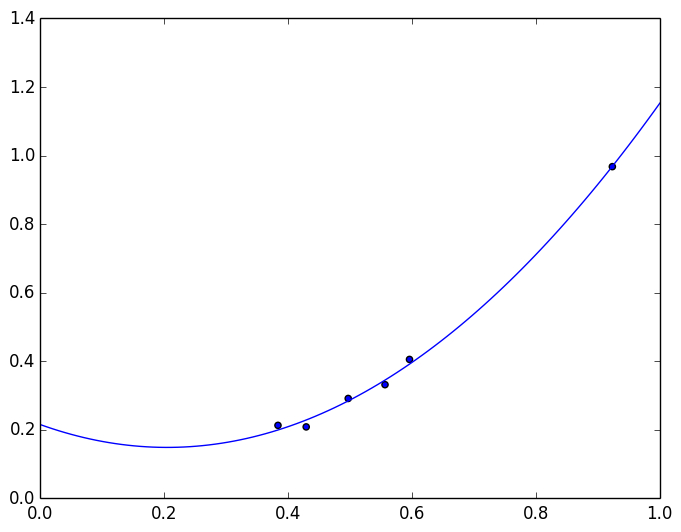

In [4]:
f = polyfit(X, Y, 2) # fit the data
scatter(X,Y)
xdom(0,1)
plot(f);

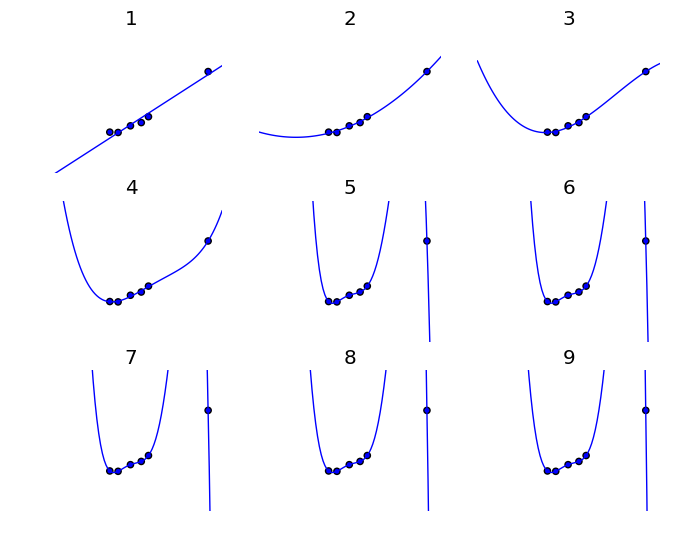

In [5]:
# try fits with different orders
order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    f = polyfit(X,Y,i)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
    title(i)
end

In [6]:
# calculate the mean squared error (MSE) of f using test points X and target values y
function mse(f, X, y)
    n = size(X,2)
    mean([(f(X[:,i]) - y[i])^2 for i = 1:n])
end

mse (generic function with 1 method)

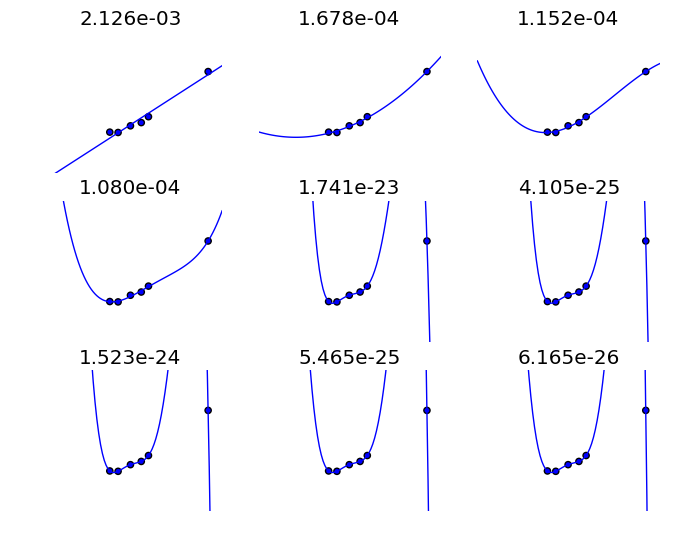

In [7]:
# compute MSE for various points
order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    f = polyfit(X,Y,i)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
    title(@sprintf("%.3e", mse(f, X, Y)))
end

How to pick the best order (and avoid overfitting)? Separate test set from training set.

# Cross Validation

In [8]:
type CVSet
    trainIndex
    testIndex
end

In [9]:
function cvSetHoldOut(n, holdOutProportion)
    perm = randperm(n)
    numTest = floor(holdOutProportion*n)
    testInd = 1:numTest
    trainInd = (numTest+1):n
    return [CVSet(perm[trainInd], perm[testInd])]
end

cvSetHoldOut (generic function with 1 method)

In [10]:
function cv(X, y, trainFunction, cvSets, lossFunction)
    loss = 0
    for i = 1:length(cvSets)
        cvSet = cvSets[i]
        # train
        Xtrain = X[:,cvSet.trainIndex]
        ytrain = y[cvSet.trainIndex]'
        f = trainFunction(Xtrain, ytrain)
        # test
        Xtest = X[:,cvSet.testIndex]
        ytest = y[cvSet.testIndex]'
        n = size(Xtest,2)
        for j = 1:n
            loss += lossFunction(f(Xtest[:,j]), ytest[j])
        end
    end
    return loss
end

cv (generic function with 1 method)

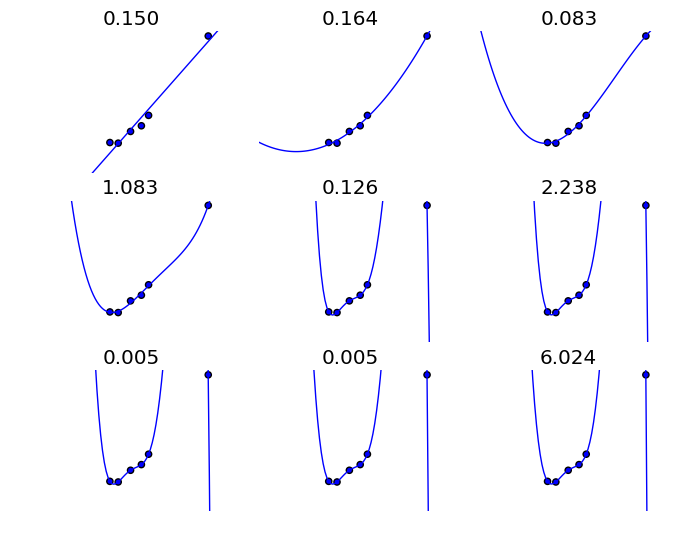

In [11]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetHoldOut(size(X,2), 0.5), sqloss)
sqloss(x,y) = (x - y)^2

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

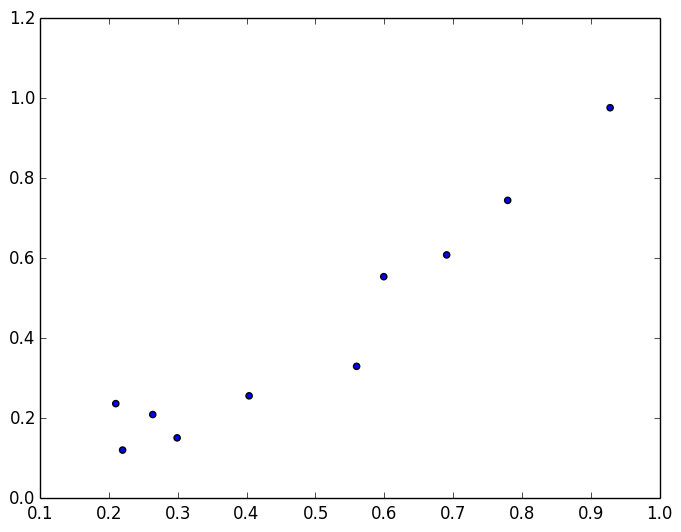

In [11]:
# let's make more samples
X = rand(10)'
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

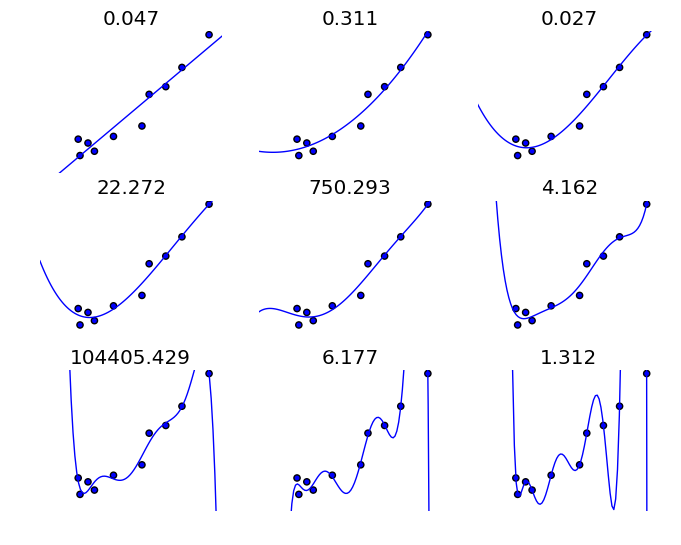

In [12]:
order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

In [13]:
function cvSetKFold(n, k)
    assert(k <= n)
    perm = randperm(n)
    sets = cell(k)
    for i = 1:k
        test = perm[i:k:n];
        train = perm[setdiff(1:n, i:k:n)]
        sets[i] = CVSet(train, test)
    end
    return sets
end

cvSetKFold (generic function with 1 method)

In [14]:
cvSetKFold(10,2)

2-element Array{Any,1}:
 CVSet([7,6,9,2,8],[10,3,5,4,1])
 CVSet([10,3,5,4,1],[7,6,9,2,8])

In [15]:
cvSetJackKnife(n) = cvSetKFold(n,n)
cvSetKFold(10,10)

10-element Array{Any,1}:
 CVSet([2,10,3,5,1,9,8,7,4],[6])
 CVSet([6,10,3,5,1,9,8,7,4],[2])
 CVSet([6,2,3,5,1,9,8,7,4],[10])
 CVSet([6,2,10,5,1,9,8,7,4],[3])
 CVSet([6,2,10,3,1,9,8,7,4],[5])
 CVSet([6,2,10,3,5,9,8,7,4],[1])
 CVSet([6,2,10,3,5,1,8,7,4],[9])
 CVSet([6,2,10,3,5,1,9,7,4],[8])
 CVSet([6,2,10,3,5,1,9,8,4],[7])
 CVSet([6,2,10,3,5,1,9,8,7],[4])

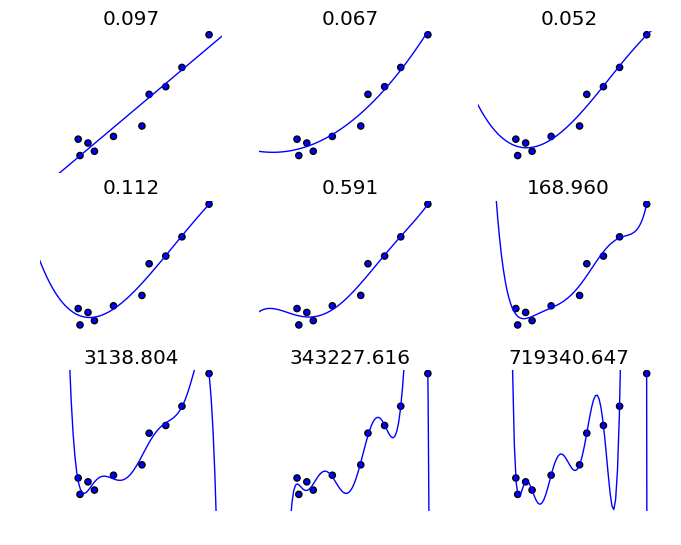

In [16]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

# Radial Basis Functions

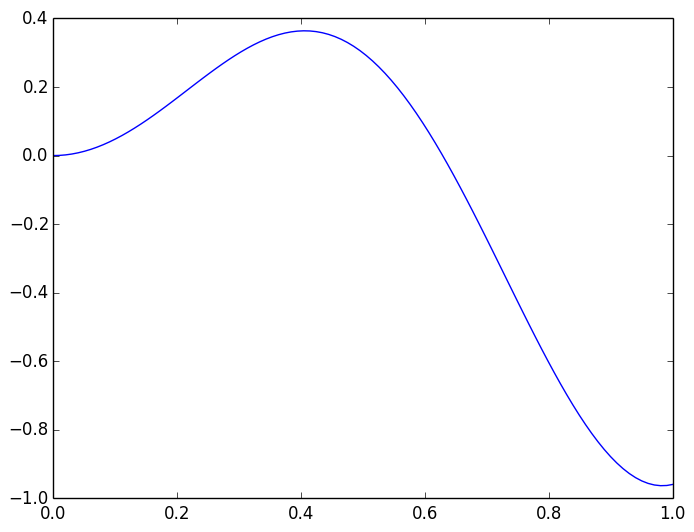

In [16]:
# true function
f = x -> x .* sin(5 .* x)
xdom(0,1)
plot(f);

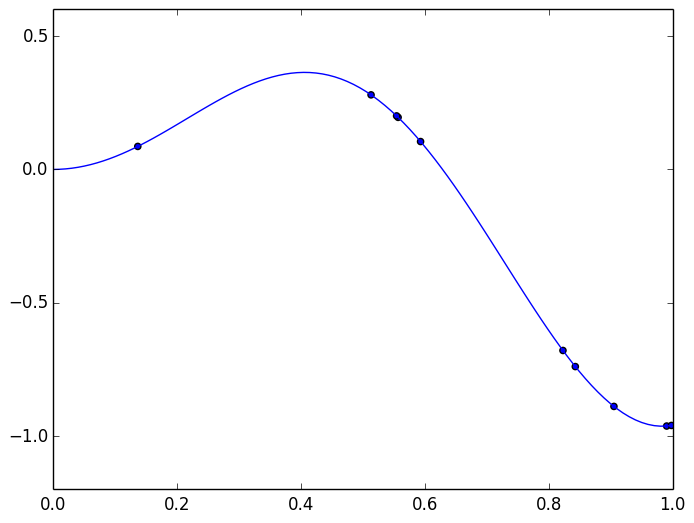

In [16]:
# Let's add some random samples from this function as the training data
X = rand(10)'
Y = f(X)
xdom(0,1)
plot(f)
scatter(X,Y);

Gram matrix $\Psi_{ij} = \psi(||x^{(i)} - x^{(j)}||)$

In [17]:
function gram(X, basisFunction)
    n = size(X,2)
    G = zeros(n,n)
    for i = 1:n
        for j = 1:n
            G[i,j] = basisFunction(norm(X[:,i] - X[:,j]))
        end
    end
    return G
end

gram (generic function with 1 method)

In [18]:
basisFunction = r->exp(-10*r^2)
gram(X, basisFunction)

10x10 Array{Float64,2}:
 1.0       0.986947  0.124869     …  0.536363    0.59016     0.194567   
 0.986947  1.0       0.171538        0.441743    0.493129    0.143211   
 0.124869  0.171538  1.0             0.00687203  0.00907015  0.000606153
 0.938215  0.98116   0.242745        0.337779    0.383689    0.0956583  
 0.378072  0.297628  0.00274426      0.961945    0.934613    0.917623   
 0.206882  0.153123  0.000691147  …  0.804832    0.755876    0.999414   
 0.985148  0.999941  0.17507         0.435612    0.486757    0.140161   
 0.536363  0.441743  0.00687203      1.0         0.99603     0.786414   
 0.59016   0.493129  0.00907015      0.99603     1.0         0.736326   
 0.194567  0.143211  0.000606153     0.786414    0.736326    1.0        

In [19]:
w = pinv(gram(X, basisFunction))*Y'

10x1 Array{Float64,2}:
  -2221.03    
  41523.2     
     -0.441342
    740.553   
   1421.4     
  -2257.51    
 -40143.7     
  -3624.83    
   2727.36    
   1834.62    

In [20]:
dot(w,[basisFunction(norm(0.3 - X[:,i])) for i = 1:size(X,2)])

0.304762859145832

In [21]:
function radialBasisInterpolation(X, y, basisFunction)
    w = pinv(gram(X, basisFunction)) * y'
    return x -> dot(w,[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])
end

radialBasisInterpolation (generic function with 1 method)

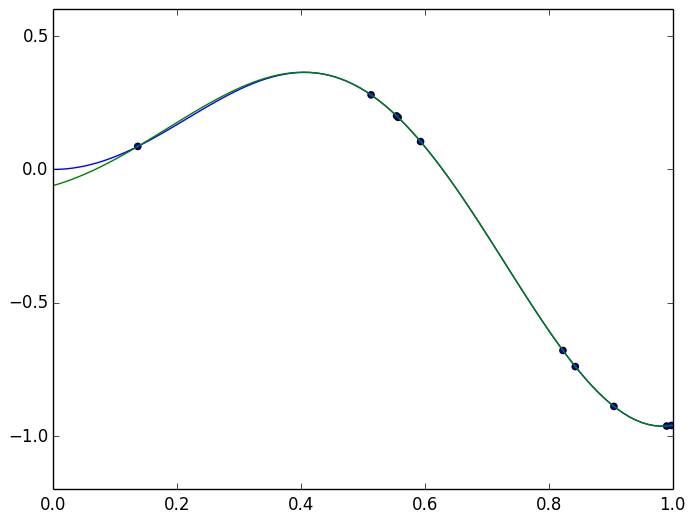

In [21]:
xdom(0,1)
plot(f)
scatter(X,Y)
plot(radialBasisInterpolation(X, Y, basisFunction));

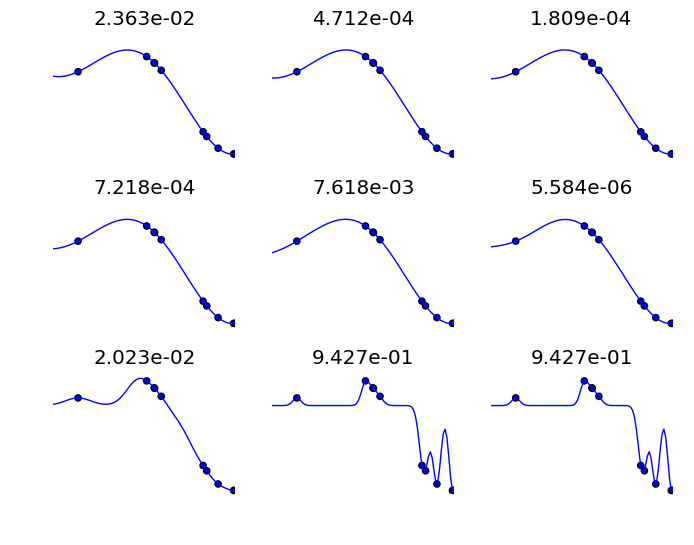

In [22]:
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
scale = [0.5 1 2 3 10 20 100 1000 1000 10000]
for j = 1:order
    subplot(numrow, numcol, j)
    scatter(X,Y)
    basisFunction = r->exp(-scale[j]*r^2)
    train(x,y) = radialBasisInterpolation(x, y, basisFunction)
    f = train(X,Y)
    plot(f)
    axis("off")
    #xlim(0,1)
    #ylim(0,1)
    title(@sprintf("%.3e", cvMetric(train)))
end

# Accomodating Noise

$w = (|\Phi + \lambda I)^+ y$ using regularization parameter $\lambda$ (should be set to the variance of the noise)

In [101]:
function radialBasisInterpolation(X, y, basisFunction, regularizationParameter)
    n = length(y)
    w = pinv(gram(X, basisFunction) + regularizationParameter * eye(n)) * y'
    return x -> dot(w,[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])
end;

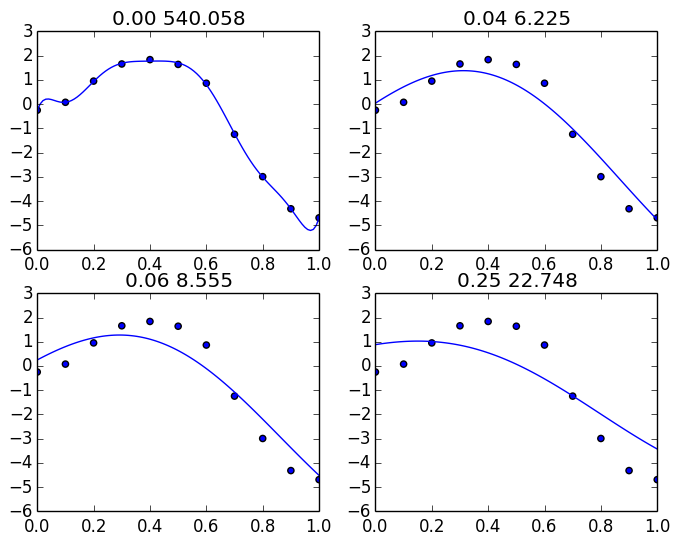

In [102]:
X = linspace(0,1,11)'
Y = 5 * X .* sin(5 .* X) .+ 0.2 * randn(11)'

cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
regularizationParameter = [0 0.2 0.25 0.5].^2
for j = 1:length(regularizationParameter)
    subplot(2, 2, j)
    scatter(X,Y)
    basisFunction = r->exp(-r^2)
    train(x,y) = radialBasisInterpolation(x, y, basisFunction, regularizationParameter[j])
    f = train(X,Y)
    plot(f)
    #axis("off")
    title(@sprintf("%.2f %.3f", regularizationParameter[j], cvMetric(train)))
end